In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import altair as alt
from altair import datum

In [8]:
def review_data_import_clean(product_name, verified_purchase = True):
    df_review = pd.read_csv('data/{}.csv'.format(product_name))
    if verified_purchase:
        df_review = df_review[df_review['verified_purchase'] == 1]
    df_review['review_date_key'] = pd.to_datetime(df_review['review_date'])
    df_review_weekly = df_review.groupby(pd.Grouper(key='review_date_key', freq='W-SUN', label='left', closed='left'))['review_rating']\
                        .agg(['mean', 'count'])\
                        .reset_index()
    df_review_weekly.rename(columns={'mean':'average_rating', 'count':'review_count'}, inplace=True)
    
    return df_review_weekly

In [3]:
def google_data_import_clean(product_name):
    df_gg = pd.read_excel('data/Google Trend.xlsx', sheet_name = product_name)
    df_gg['week_key'] = pd.to_datetime(df_gg['Week'])
    
    df_gg.rename(columns = {df_gg.columns[1]:'trend_index'}, inplace = True)
    df_gg_filter = df_gg[df_gg['trend_index'].cumsum() > 0]
    
    return df_gg_filter

In [4]:
def data_import_clean(product_name, price, verified_purchase = 1):
    
    df_review_clean = review_data_import_clean(product_name, verified_purchase)
    df_gg_clean = google_data_import_clean(product_name)
    
    df = df_review_clean.merge(df_gg_clean, left_on = 'review_date_key', right_on='week_key', how='right')
    df['product_name'] = product_name
    df['price'] = price
    df = df.sort_values('week_key').reset_index().drop('index', axis=1)
    
    return df

In [5]:
def calculate_correlation_review_count(df):
    corr_lst = [(i, df['review_count'].corr(df['trend_index'].shift(i))) for i in range(len(df)//2)]
    df_corr = pd.DataFrame(corr_lst, columns=['lag', 'corr'])
    df_corr['product_name'] = df['product_name'][0]
    df_corr['price'] = df['price'][0]
    return df_corr

In [6]:
def calculate_correlation_review_rating(df):
    corr_lst = [(i, df['average_rating'].corr(df['trend_index'].shift(i))) for i in range(len(df)//2)]
    df_corr = pd.DataFrame(corr_lst, columns=['lag', 'corr'])
    df_corr['product_name'] = df['product_name'][0]
    df_corr['price'] = df['price'][0]
    return df_corr

In [9]:
product_list = ['AirPods Pro', 'Elite 75t', 'Free', 'Galaxy Buds Plus', 'NC700', 'Soundcore Liberty 2 Pro', 'Soundcore Liberty Air 2', 'Soundcore Life Q20', 'WF-1000XM3']
price_list = [249.0, 179.0, 49.0, 149.0, 399.0, 149.0, 100.0, 59.0, 198.0]

In [10]:
df_corr_review_count = pd.DataFrame(columns=['lag', 'corr', 'product_name', 'price'])

for product, price in zip(*[product_list, price_list]):
    df = data_import_clean(product, price, True)
    df_corr_review_count = pd.concat([df_corr_review_count, calculate_correlation_review_count(df)])
    
df_corr_review_count['segment'] = pd.cut(df_corr_review_count['price'], bins=[0,100,150,200,1000], labels=['Below 100', '100 to 150', '150 to 200', 'Above 200'], right=False)

In [11]:
df_corr_review_count

,lag,corr,product_name,price,segment
0,0,-0.316013,AirPods Pro,249.0,Above 200
1,1,0.074203,AirPods Pro,249.0,Above 200
2,2,0.376190,AirPods Pro,249.0,Above 200
3,3,0.412419,AirPods Pro,249.0,Above 200
4,4,0.427761,AirPods Pro,249.0,Above 200
...,...,...,...,...,...
17,17,-0.172343,WF-1000XM3,198.0,150 to 200
18,18,-0.033549,WF-1000XM3,198.0,150 to 200
19,19,-0.147340,WF-1000XM3,198.0,150 to 200
20,20,-0.421058,WF-1000XM3,198.0,150 to 200


A good correlation can be found for more expensive products after shifting Google Trend data by 6 to 9 weeks

In [12]:
alt.Chart(df_corr_review_count).mark_bar(size=10).encode(
    x=alt.X('lag:O'),
    y=alt.Y('corr:Q'),
    facet=alt.Facet(
        'product_name',
        columns=1,
        sort=['price']
    )
).resolve_scale(x='independent')

alt.Chart(...)

In [17]:
circle = alt.Chart(df_corr_review_count).mark_circle(
    size = 50
).transform_window(
        sort=[alt.SortField("corr", order="descending")], 
        rank="rank(corr)",
        groupby=['segment','product_name']
).transform_filter(
    alt.datum.rank == 1
).encode(
        x=alt.X("lag:O"), 
        y=alt.Y("corr:Q"),
        color=alt.Color('product_name:N', title='Product Name'),
)

text = alt.Chart(df_corr_review_count).mark_text(
    dy=-10, 
    dx=-15,
    color="red"
).transform_window(
        sort=[alt.SortField("corr", order="descending")], 
        rank="rank(corr)",
        groupby=['segment','product_name']
).transform_filter(
    alt.datum.rank == 1
).encode(
        x=alt.X("lag:O"), 
        y=alt.Y("corr:Q"),
        text=alt.Text("product_name:N"),
)

(circle + text).facet(
    column=alt.Column('segment', sort=['Below 100', '100 to 150', '150 to 200', 'Above 200'])
).properties(
    title='Best Correlation Found for Each Product in Different Price Segments')

alt.FacetChart(...)

Take Soundcore Liberty Air 2 as an example to visualize the correlation between normalized weekly review count and shifted weekly Google trend index

In [70]:
df_sc_air_2 = data_import_clean('Soundcore Liberty Air 2', 100)
df_sc_air_2['trend_index_shifted'] = df_sc_air_2['trend_index'].shift(5)
df_sc_air_2.dropna(subset=['review_count', 'trend_index_shifted'], how='any', inplace=True)
df_sc_air_2['review_count_normalized'] = (df_sc_air_2['review_count']/df_sc_air_2['review_count'].max()*100).astype(int)

alt.Chart(df_sc_air_2).mark_line().transform_fold(
    fold=['review_count_normalized', 'trend_index_shifted'], 
    as_=['variable', 'value']
).encode(
    x='week_key',
    y='value:Q',
    color='variable:N'
)

alt.Chart(...)

Another example of WF-1000XM3

In [19]:
df_wf_1000_xm3 = data_import_clean('WF-1000XM3', 100)
df_wf_1000_xm3['trend_index_shifted'] = df_wf_1000_xm3['trend_index'].shift(9)
df_wf_1000_xm3.dropna(subset=['review_count', 'trend_index_shifted'], how='any', inplace=True)
df_wf_1000_xm3['review_count_normalized'] = (df_wf_1000_xm3['review_count']/df_wf_1000_xm3['review_count'].max()*100).astype(int)

alt.Chart(df_wf_1000_xm3).mark_line().transform_fold(
    fold=['review_count_normalized', 'trend_index_shifted'], 
    as_=['variable', 'value']
).encode(
    x='week_key',
    y='value:Q',
    color='variable:N'
)

alt.Chart(...)

Example of Elite 75t

In [20]:
df_elite_75t = data_import_clean('Elite 75t', 100)
df_elite_75t['trend_index_shifted'] = df_elite_75t['trend_index'].shift(9)
df_elite_75t.dropna(subset=['review_count', 'trend_index_shifted'], how='any', inplace=True)
df_elite_75t['review_count_normalized'] = (df_elite_75t['review_count']/df_elite_75t['review_count'].max()*100).astype(int)

alt.Chart(df_elite_75t).mark_line().transform_fold(
    fold=['review_count_normalized', 'trend_index_shifted'], 
    as_=['variable', 'value']
).encode(
    x='week_key',
    y='value:Q',
    color='variable:N'
)

alt.Chart(...)

Example of NC700

In [21]:
df_nc_700 = data_import_clean('NC700', 100)
df_nc_700['trend_index_shifted'] = df_nc_700['trend_index'].shift(6)
df_nc_700.dropna(subset=['review_count', 'trend_index_shifted'], how='any', inplace=True)
df_nc_700['review_count_normalized'] = (df_nc_700['review_count']/df_nc_700['review_count'].max()*100).astype(int)

alt.Chart(df_nc_700).mark_line().transform_fold(
    fold=['review_count_normalized', 'trend_index_shifted'], 
    as_=['variable', 'value']
).encode(
    x='week_key',
    y='value:Q',
    color='variable:N'
)

alt.Chart(...)

Example of AirPods Pro

In [22]:
df_airpods_pro = data_import_clean('AirPods Pro', 100)
df_airpods_pro['trend_index_shifted'] = df_airpods_pro['trend_index'].shift(9)
df_airpods_pro.dropna(subset=['review_count', 'trend_index_shifted'], how='any', inplace=True)
df_airpods_pro['review_count_normalized'] = (df_airpods_pro['review_count']/df_airpods_pro['review_count'].max()*100).astype(int)

alt.Chart(df_airpods_pro).mark_line().transform_fold(
    fold=['review_count_normalized', 'trend_index_shifted'], 
    as_=['variable', 'value']
).encode(
    x='week_key',
    y='value:Q',
    color='variable:N'
)

alt.Chart(...)

Correlation without filtering for verified purchase

In [25]:
df_corr_review_count = pd.DataFrame(columns=['lag', 'corr', 'product_name', 'price'])

for product, price in zip(*[product_list, price_list]):
    df = data_import_clean(product, price, False)
    df_corr_review_count = pd.concat([df_corr_review_count, calculate_correlation_review_count(df)])
    
df_corr_review_count['segment'] = pd.cut(df_corr_review_count['price'], bins=[0,100,150,200,1000], labels=['Below 100', '100 to 150', '150 to 200', 'Above 200'], right=False)

In [27]:
circle = alt.Chart(df_corr_review_count).mark_circle(
    size = 50
).transform_window(
        sort=[alt.SortField("corr", order="descending")], 
        rank="rank(corr)",
        groupby=['segment','product_name']
).transform_filter(
    alt.datum.rank == 1
).encode(
        x=alt.X("lag:O"), 
        y=alt.Y("corr:Q"),
        color=alt.Color('product_name:N', title='Product Name'),
)

text = alt.Chart(df_corr_review_count).mark_text(
    dy=-10, 
    dx=-15,
    color="red"
).transform_window(
        sort=[alt.SortField("corr", order="descending")], 
        rank="rank(corr)",
        groupby=['segment','product_name']
).transform_filter(
    alt.datum.rank == 1
).encode(
        x=alt.X("lag:O"), 
        y=alt.Y("corr:Q"),
        text=alt.Text("product_name:N"),
)

(circle + text).facet(
    column=alt.Column('segment', sort=['Below 100', '100 to 150', '150 to 200', 'Above 200'])
).properties(
    title='Best Correlation Found for Each Product in Different Price Segments')

alt.FacetChart(...)

**Correlation between review counts of all reviews and verified purchase only**

In [48]:
review_count_corr = []
for product in product_list:
    df_review_all = review_data_import_clean(product, False)
    df_review_verified_purchase = review_data_import_clean(product, True)
    corr = df_review_all['review_count'].corr(df_review_verified_purchase['review_count'])
    review_count_corr.append((product, corr))

In [52]:
df_review_count_corr = pd.DataFrame(review_count_corr, columns=['product_name', 'correlation'])

In [63]:
alt.Chart(df_review_count_corr).mark_bar().encode(
    x=alt.X('product_name', title='Product Name', sort='-y'),
    y=alt.Y('correlation', title='Correlation'),
).properties(title='Correlation of Review Counts Between All Reviews and Verified Purchasing Reviews', width=500)

alt.Chart(...)

**Correlation between review rating of all reviews and verified purchase only**

In [65]:
review_rating_corr = []
for product in product_list:
    df_review_all = review_data_import_clean(product, False)
    df_review_verified_purchase = review_data_import_clean(product, True)
    corr = df_review_all['average_rating'].corr(df_review_verified_purchase['average_rating'])
    review_rating_corr.append((product, corr))

In [66]:
df_review_rating_corr = pd.DataFrame(review_rating_corr, columns=['product_name', 'correlation'])

In [69]:
alt.Chart(df_review_rating_corr).mark_bar().encode(
    x=alt.X('product_name', title='Product Name', sort='-y'),
    y=alt.Y('correlation', title='Correlation'),
).properties(title='Correlation of Average Ratings Between All Reviews and Verified Purchasing Reviews', width=500)

alt.Chart(...)

On the other hand, there is no good correlation between review rating and Google Trend for any shifted periods.

In [23]:
df_corr_review_rating = pd.DataFrame(columns=['lag', 'corr', 'product_name', 'price'])

for product, price in zip(*[product_list, price_list]):
    df = data_import_clean(product, price)
    df_corr_review_rating = pd.concat([df_corr_review_rating, calculate_correlation_review_rating(df)])
    
df_corr_review_rating['segment'] = pd.cut(df_corr_review_rating['price'], bins=[0,100,150,200,1000], labels=['Below 100', '100 to 150', '150 to 200', 'Above 200'], right=False)

In [24]:
df_corr_review_rating

,lag,corr,product_name,price,segment
0,0,0.296331,AirPods Pro,249.0,Above 200
1,1,0.248517,AirPods Pro,249.0,Above 200
2,2,0.268443,AirPods Pro,249.0,Above 200
3,3,0.324300,AirPods Pro,249.0,Above 200
4,4,0.455515,AirPods Pro,249.0,Above 200
...,...,...,...,...,...
17,17,-0.029099,WF-1000XM3,198.0,150 to 200
18,18,-0.088879,WF-1000XM3,198.0,150 to 200
19,19,0.013955,WF-1000XM3,198.0,150 to 200
20,20,-0.143263,WF-1000XM3,198.0,150 to 200


In [21]:
alt.Chart(df_corr_review_rating).mark_bar(size=10).encode(
    x=alt.X('lag:O'),
    y=alt.Y('corr:Q'),
    facet=alt.Facet(
        'product_name',
        columns=1,
        sort=['price']
    )
).resolve_scale(x='independent')

alt.Chart(...)

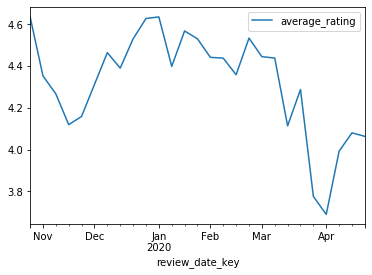

In [24]:
df = review_data_import_clean('AirPods Pro')
df.plot('review_date_key', 'average_rating')

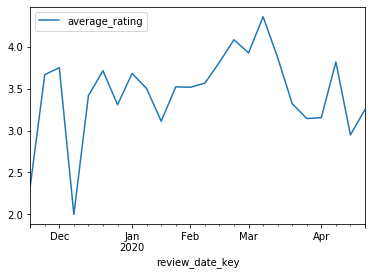

In [25]:
df = review_data_import_clean('Elite 75t')
df.plot('review_date_key', 'average_rating')

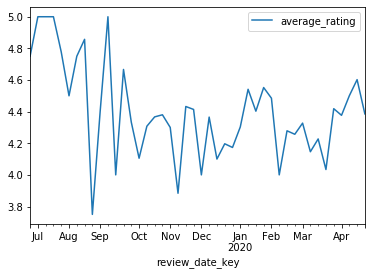

In [26]:
df = review_data_import_clean('Free')
df.plot('review_date_key', 'average_rating')

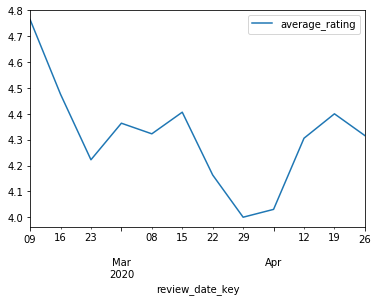

In [27]:
df = review_data_import_clean('Galaxy Buds Plus')
df.plot('review_date_key', 'average_rating')

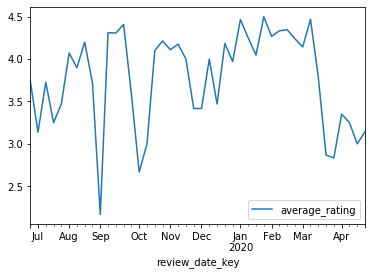

In [29]:
df = review_data_import_clean('NC700')
df.plot('review_date_key', 'average_rating')

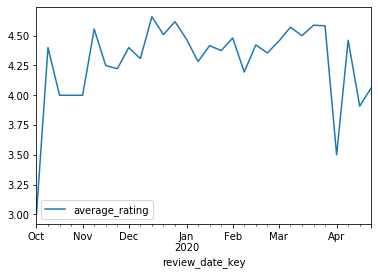

In [30]:
df = review_data_import_clean('Soundcore Liberty 2 Pro')
df.plot('review_date_key', 'average_rating')

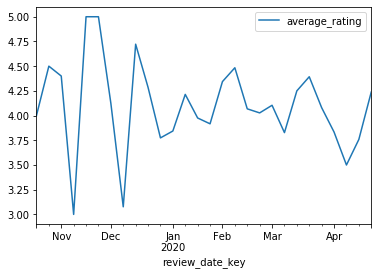

In [31]:
df = review_data_import_clean('Soundcore Liberty Air 2')
df.plot('review_date_key', 'average_rating')

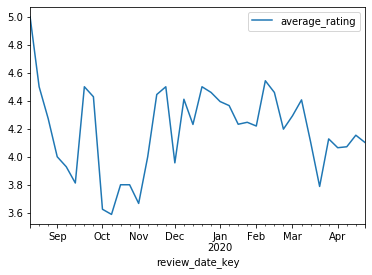

In [32]:
df = review_data_import_clean('Soundcore Life Q20')
df.plot('review_date_key', 'average_rating')

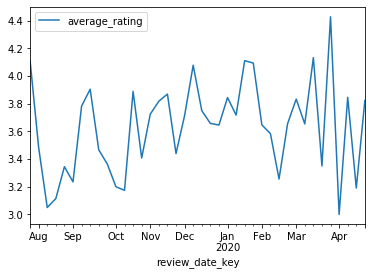

In [33]:
df = review_data_import_clean('WF-1000XM3')
df.plot('review_date_key', 'average_rating')